

BaseLine



Jumlah baris sebelum menghapus duplikat: 196331
Jumlah baris setelah menghapus duplikat: 196331

=== Proporsi Kelas ===
susceptibility
RESISTANT       0.439783
INTERMEDIATE    0.407608
SUSCEPTIBLE     0.152610
Name: proportion, dtype: float64

=== Jumlah Kelas di Data Training ===
susceptibility
RESISTANT       69074
INTERMEDIATE    64020
SUSCEPTIBLE     23970
Name: count, dtype: int64

=== Jumlah Kelas di Data Testing ===
susceptibility
RESISTANT       17269
INTERMEDIATE    16006
SUSCEPTIBLE      5992
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

INTERMEDIATE       0.78      0.79      0.78     16006
   RESISTANT       0.74      0.89      0.81     17269
 SUSCEPTIBLE       1.00      0.34      0.51      5992

    accuracy                           0.77     39267
   macro avg       0.84      0.68      0.70     39267
weighted avg       0.79      0.77      0.75     39267


=== Confusion Matrix ===
[[12681  3320     5]
 [ 1843

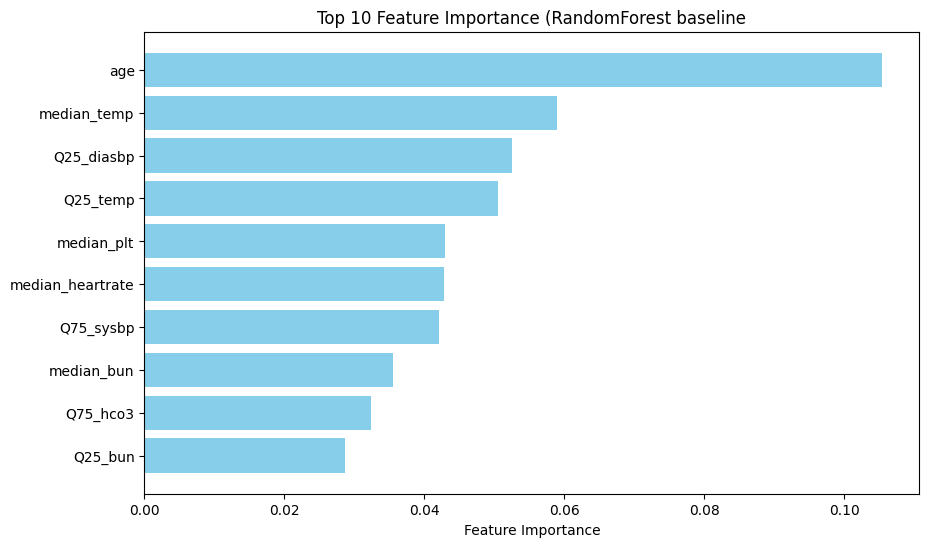


=== Cross-Validation (5-Fold) ===
F1-macro per fold: [0.68254714 0.68368866 0.68558053 0.68878725 0.67539108]
Rata-rata F1-macro: 0.6831989318306326


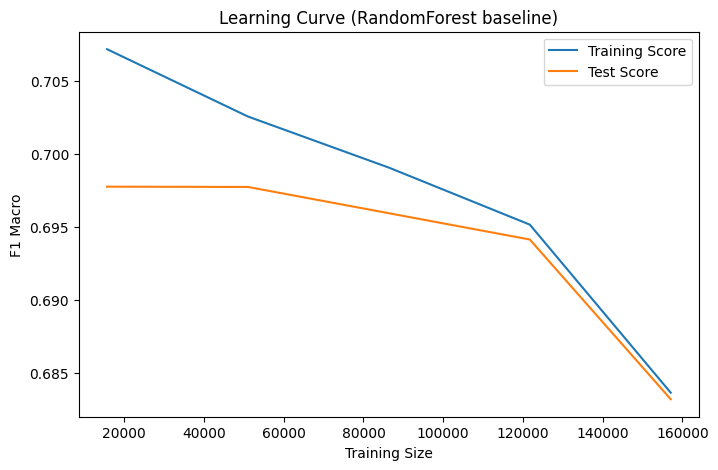

In [1]:
# === 0. Setup Google Drive ===
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# === 1. Baca file ===
file_path = "/content/drive/MyDrive/Colab Notebooks/Data Train.csv"
df = pd.read_csv(file_path)

# === 2. Hapus duplikat & kolom tidak perlu ===
print(f"Jumlah baris sebelum menghapus duplikat: {len(df)}")
df = df.drop_duplicates()
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

df = df.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")

# === 3. Target ===
target = "susceptibility"
df[target] = df[target].str.strip().str.upper()

# === 4. Fitur kategorikal & numerik ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df.columns if c not in exclude_cols]

X = df[categorical_features + numeric_features]
y = df[target]

print("\n=== Proporsi Kelas ===")
print(y.value_counts(normalize=True))

# === 5. Preprocessing ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="NONE")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), [c for c in numeric_features if c not in special_numeric]),

        ("special_num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), special_numeric)
    ],
    remainder="drop"
)

# === 6. Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 7. Pipeline dengan class_weight='balanced' ===
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ))
])

# === 8. Latih model ===
rf_model.fit(X_train, y_train)

print("\n=== Jumlah Kelas di Data Training ===")
print(y_train.value_counts())

print("\n=== Jumlah Kelas di Data Testing ===")
print(y_test.value_counts())

# === 9. Evaluasi model ===
y_pred = rf_model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 10. Feature Importance ===
rf = rf_model.named_steps["classifier"]
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]

feature_names_cat = list(ohe.get_feature_names_out(categorical_features))
feature_names_num = [c for c in numeric_features if c not in special_numeric]
feature_names_special = special_numeric
feature_names = feature_names_cat + feature_names_num + feature_names_special

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)

print(f"\n=== Top {top_n} Feature Importance ===")
print(feature_importance_df.head(top_n))

# === 11. Visualisasi Feature Importance ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importance (RandomForest baseline")
plt.show()

# === 12. Cross-validation ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n=== Cross-Validation (5-Fold) ===")
print("F1-macro per fold:", scores)
print("Rata-rata F1-macro:", scores.mean())

#=== 13. Learning Curve ===
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y, cv=cv, scoring='f1_macro', n_jobs=-1
)


train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Test Score")
plt.xlabel("Training Size")
plt.ylabel("F1 Macro")
plt.title("Learning Curve (RandomForest baseline)")
plt.legend()
plt.show()





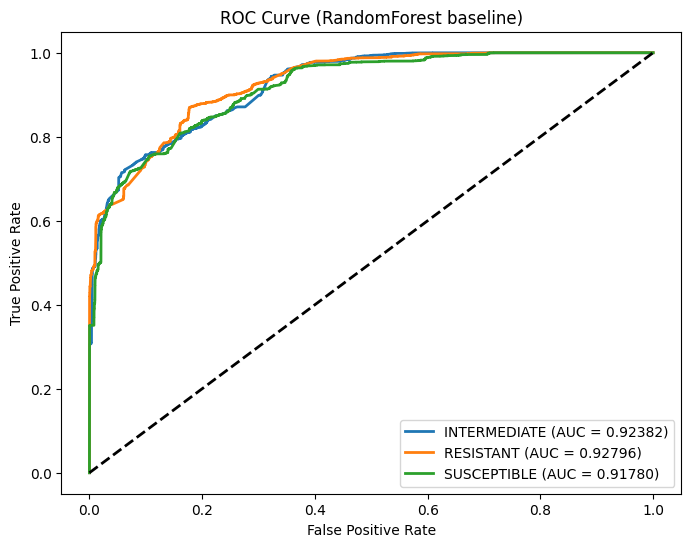

=== AUC Score per Class ===
INTERMEDIATE: 0.9238
RESISTANT: 0.9280
SUSCEPTIBLE: 0.9178


In [2]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# === ROC Curve (Multi-Class) ===

# Pastikan label-nya diurutkan konsisten
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilitas prediksi dari model
y_score = rf_model.predict_proba(X_test)

# Dictionary untuk simpan skor AUC
roc_auc_scores = {}

plt.figure(figsize=(8, 6))

# Loop untuk setiap kelas
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i],
                            y_score[i][:, 1] if isinstance(y_score, list) else y_score[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[class_name] = roc_auc  # simpan nilai AUC

    # Plot ROC
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.5f})")

# Plot diagonal random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForest baseline)")
plt.legend(loc="lower right")
plt.show()

# === Print AUC per kelas ===
print("=== AUC Score per Class ===")
for cls, score in roc_auc_scores.items():
    print(f"{cls}: {score:.4f}")


validase baseline

In [3]:
#SMOTE Model

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Load data validasi ===
df_val = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/DataVal.csv")

df_val = df_val.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")


# === 2. Samakan preprocessing target EXACTLY seperti data training ===
df_val["susceptibility"] = df_val["susceptibility"].str.strip().str.upper()

# === 3. Gunakan fitur yang sama seperti saat training ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

target = "susceptibility"

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df_val.columns if c not in exclude_cols]

X_val = df_val[categorical_features + numeric_features]
y_val = df_val[target]

# === 4. Prediksi menggunakan pipeline model ===
y_pred = rf_model.predict(X_val)

# === 5. Evaluasi ===
print("=== Classification Report (Validation Data) ===")
print(classification_report(y_val, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_val, y_pred))


=== Classification Report (Validation Data) ===
              precision    recall  f1-score   support

INTERMEDIATE       0.77      0.78      0.78      8970
   RESISTANT       0.74      0.89      0.81      9618
 SUSCEPTIBLE       1.00      0.33      0.50      3227

    accuracy                           0.76     21815
   macro avg       0.84      0.67      0.69     21815
weighted avg       0.79      0.76      0.75     21815


=== Confusion Matrix ===
[[7030 1940    0]
 [1059 8559    0]
 [1043 1108 1076]]


In [4]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # === 1. Load data ===
# file_path = "/content/drive/MyDrive/Colab Notebooks/ecoli_cleaned_dropped_cols.csv"
# df = pd.read_csv(file_path)

# print("Total data:", len(df))

# # === 2. Split 90% (train+val) dan 10% (final validation) ===
# df_train_val, df_final_val = train_test_split(
#     df,
#     test_size=0.10,      # 10%
#     random_state=42,     # agar hasil konsisten
#     shuffle=True         # acak datanya
# )

# print("Data train+val:", len(df_train_val))
# print("Data final validation:", len(df_final_val))

# # === 3. Simpan ke file baru ===
# df_train_val.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Train.csv", index=False)
# df_final_val.to_csv("/content/drive/MyDrive/Colab Notebooks/DataVal.csv", index=False)

# print("File berhasil disimpan!")


In [5]:
# file_path = "/content/drive/MyDrive/Colab Notebooks/Data Train.csv"
# df = pd.read_csv(file_path)
# print(df.shape)
# df_val = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/DataVal.csv")
# print(df_val.shape)

ClassWeight

Jumlah baris sebelum menghapus duplikat: 196331
Jumlah baris setelah menghapus duplikat: 196331

=== Proporsi Kelas ===
susceptibility
RESISTANT       0.439783
INTERMEDIATE    0.407608
SUSCEPTIBLE     0.152610
Name: proportion, dtype: float64

=== Jumlah Kelas di Data Training ===
susceptibility
RESISTANT       69074
INTERMEDIATE    64020
SUSCEPTIBLE     23970
Name: count, dtype: int64

=== Jumlah Kelas di Data Testing ===
susceptibility
RESISTANT       17269
INTERMEDIATE    16006
SUSCEPTIBLE      5992
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

INTERMEDIATE       0.83      0.75      0.79     16006
   RESISTANT       0.80      0.80      0.80     17269
 SUSCEPTIBLE       0.61      0.77      0.68      5992

    accuracy                           0.78     39267
   macro avg       0.75      0.77      0.76     39267
weighted avg       0.78      0.78      0.78     39267


=== Confusion Matrix ===
[[11966  2813  1227]
 [ 1730

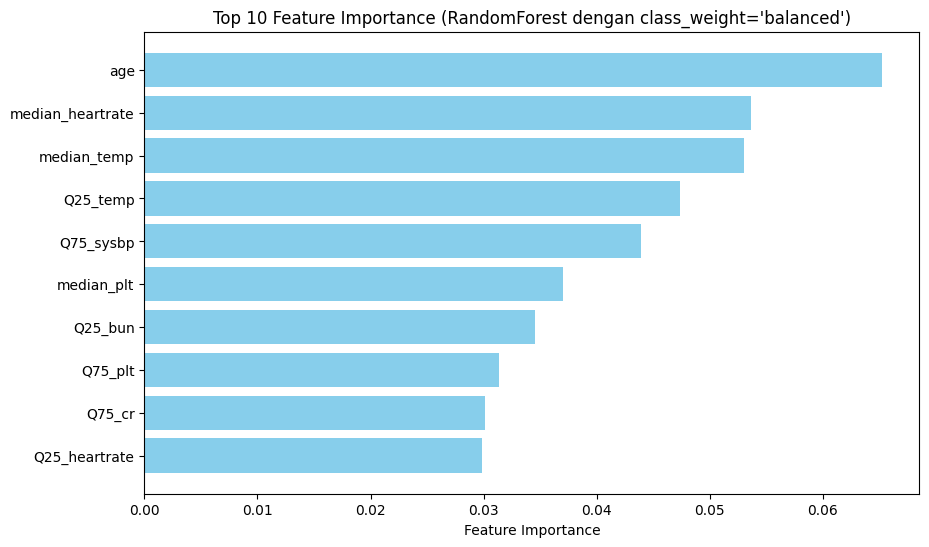


=== Cross-Validation (5-Fold) ===
F1-macro per fold: [0.74391499 0.76332882 0.75214182 0.76836885 0.75101558]
Rata-rata F1-macro: 0.7557540135954868


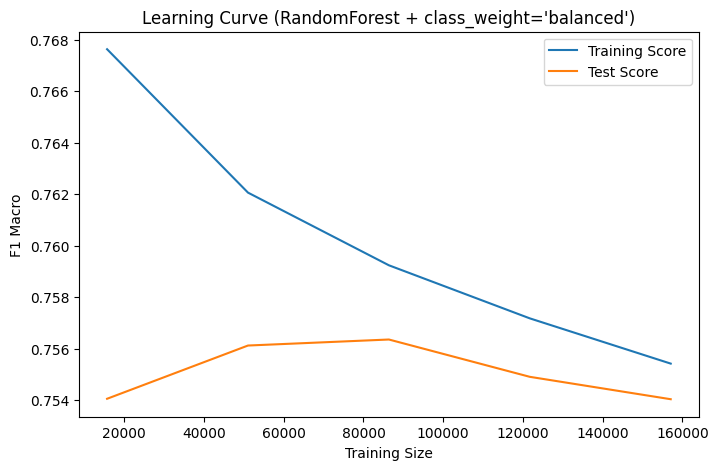

In [6]:
# === 0. Setup Google Drive ===
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# === 1. Baca file ===
file_path = "/content/drive/MyDrive/Colab Notebooks/Data Train.csv"
df = pd.read_csv(file_path)

# === 2. Hapus duplikat & kolom tidak perlu ===
print(f"Jumlah baris sebelum menghapus duplikat: {len(df)}")
df = df.drop_duplicates()
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

df = df.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")

# === 3. Target ===
target = "susceptibility"
df[target] = df[target].str.strip().str.upper()

# === 4. Fitur kategorikal & numerik ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df.columns if c not in exclude_cols]

X = df[categorical_features + numeric_features]
y = df[target]

print("\n=== Proporsi Kelas ===")
print(y.value_counts(normalize=True))

# === 5. Preprocessing ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="NONE")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), [c for c in numeric_features if c not in special_numeric]),

        ("special_num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), special_numeric)
    ],
    remainder="drop"
)

# === 6. Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 7. Pipeline dengan class_weight='balanced' ===
rf_modelCW = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        class_weight='balanced',   # 💡 ini bagian penting untuk handle imbalance
        random_state=42,
        n_jobs=-1
    ))
])

# === 8. Latih model ===
rf_modelCW.fit(X_train, y_train)

print("\n=== Jumlah Kelas di Data Training ===")
print(y_train.value_counts())

print("\n=== Jumlah Kelas di Data Testing ===")
print(y_test.value_counts())

# === 9. Evaluasi model ===
y_pred = rf_modelCW.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 10. Feature Importance ===
rf = rf_modelCW.named_steps["classifier"]
ohe = rf_modelCW.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]

feature_names_cat = list(ohe.get_feature_names_out(categorical_features))
feature_names_num = [c for c in numeric_features if c not in special_numeric]
feature_names_special = special_numeric
feature_names = feature_names_cat + feature_names_num + feature_names_special

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)

print(f"\n=== Top {top_n} Feature Importance ===")
print(feature_importance_df.head(top_n))

# === 11. Visualisasi Feature Importance ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importance (RandomForest dengan class_weight='balanced')")
plt.show()

# === 12. Cross-validation ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_modelCW, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n=== Cross-Validation (5-Fold) ===")
print("F1-macro per fold:", scores)
print("Rata-rata F1-macro:", scores.mean())

#=== 13. Learning Curve ===
train_sizes, train_scores, test_scores = learning_curve(
    rf_modelCW, X, y, cv=cv, scoring='f1_macro', n_jobs=-1
)


train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Test Score")
plt.xlabel("Training Size")
plt.ylabel("F1 Macro")
plt.title("Learning Curve (RandomForest + class_weight='balanced')")
plt.legend()
plt.show()


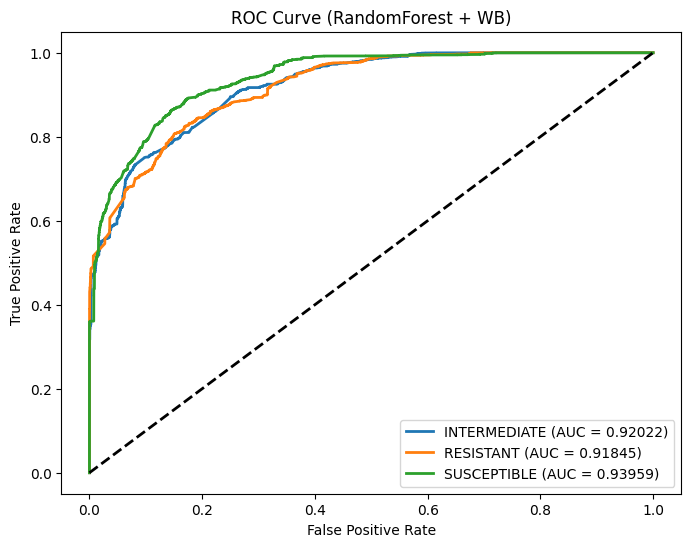

=== AUC Score per Class ===
INTERMEDIATE: 0.9202
RESISTANT: 0.9184
SUSCEPTIBLE: 0.9396


In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# === ROC Curve (Multi-Class) ===

# Pastikan label-nya diurutkan konsisten
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilitas prediksi dari model
y_score = rf_modelCW.predict_proba(X_test)

# Dictionary untuk simpan skor AUC
roc_auc_scores = {}

plt.figure(figsize=(8, 6))

# Loop untuk setiap kelas
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i],
                            y_score[i][:, 1] if isinstance(y_score, list) else y_score[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[class_name] = roc_auc  # simpan nilai AUC

    # Plot ROC
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.5f})")

# Plot diagonal random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForest + WB)")
plt.legend(loc="lower right")
plt.show()

# === Print AUC per kelas ===
print("=== AUC Score per Class ===")
for cls, score in roc_auc_scores.items():
    print(f"{cls}: {score:.4f}")


In [8]:
#CW Model

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Load data validasi ===
df_val = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/DataVal.csv")

df = df.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")


# === 2. Samakan preprocessing target EXACTLY seperti data training ===
df_val["susceptibility"] = df_val["susceptibility"].str.strip().str.upper()

# === 3. Gunakan fitur yang sama seperti saat training ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

target = "susceptibility"

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df_val.columns if c not in exclude_cols]

X_val = df_val[categorical_features + numeric_features]
y_val = df_val[target]

# === 4. Prediksi menggunakan pipeline model ===
y_pred = rf_modelCW.predict(X_val)

# === 5. Evaluasi ===
print("=== Classification Report (Validation Data) ===")
print(classification_report(y_val, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_val, y_pred))


=== Classification Report (Validation Data) ===
              precision    recall  f1-score   support

INTERMEDIATE       0.82      0.74      0.78      8970
   RESISTANT       0.79      0.79      0.79      9618
 SUSCEPTIBLE       0.59      0.74      0.66      3227

    accuracy                           0.76     21815
   macro avg       0.73      0.76      0.74     21815
weighted avg       0.77      0.76      0.77     21815


=== Confusion Matrix ===
[[6642 1649  679]
 [ 998 7635  985]
 [ 499  329 2399]]


SMOTE

Jumlah baris sebelum menghapus duplikat: 196331
Jumlah baris setelah menghapus duplikat: 196331

=== Proporsi Kelas Sebelum SMOTE ===
susceptibility
RESISTANT       86343
INTERMEDIATE    80026
SUSCEPTIBLE     29962
Name: count, dtype: int64

=== Jumlah Kelas Data Train (Sebelum SMOTE) ===
susceptibility
RESISTANT       69074
INTERMEDIATE    64020
SUSCEPTIBLE     23970
Name: count, dtype: int64

=== Jumlah Kelas Data Test ===
susceptibility
RESISTANT       17269
INTERMEDIATE    16006
SUSCEPTIBLE      5992
Name: count, dtype: int64

=== Jumlah Kelas Setelah SMOTE (Training Set) ===
INTERMEDIATE    69074
RESISTANT       69074
SUSCEPTIBLE     69074
dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

INTERMEDIATE       0.85      0.75      0.80     16006
   RESISTANT       0.80      0.81      0.81     17269
 SUSCEPTIBLE       0.59      0.76      0.66      5992

    accuracy                           0.78     39267
   macro avg       0.75      0.

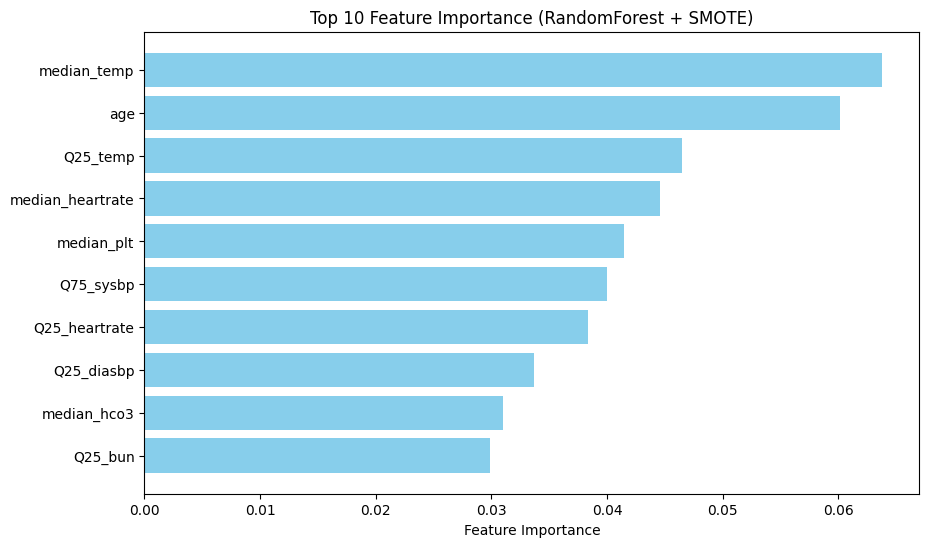


=== Cross-Validation (5-Fold) ===
F1-macro per fold: [0.74341286 0.7657868  0.75759138 0.76346957 0.75082017]
Rata-rata F1-macro: 0.756216152751491


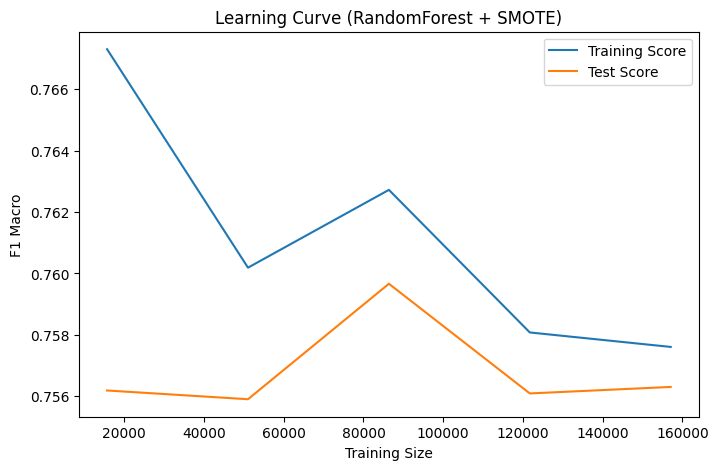

In [9]:
# === 0. Setup Google Drive ===
# from google.colab import drive
# drive.mount('/content/drive')

# === 1. Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

# === 2. Baca file dari Google Drive ===
file_path = "/content/drive/MyDrive/Colab Notebooks/Data Train.csv"
df = pd.read_csv(file_path)

# === 3. Hapus duplikat & kolom tidak perlu ===
print(f"Jumlah baris sebelum menghapus duplikat: {len(df)}")
df = df.drop_duplicates()
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

df = df.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")

# === 4. Target ===
target = "susceptibility"
df[target] = df[target].str.strip().str.upper()

# === 5. Tentukan fitur kategorikal & numerik ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df.columns if c not in exclude_cols]

X = df[categorical_features + numeric_features]
y = df[target]

print("\n=== Proporsi Kelas Sebelum SMOTE ===")
print(y.value_counts())

# === 6. Preprocessing ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="NONE")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), [c for c in numeric_features if c not in special_numeric]),

        ("special_num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), special_numeric)
    ],
    remainder="drop"
)

# === 7. Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("\n=== Jumlah Kelas Data Train (Sebelum SMOTE) ===")
print(y_train.value_counts())
print("\n=== Jumlah Kelas Data Test ===")
print(y_test.value_counts())

# === 8. Pipeline lengkap dengan SMOTE + RandomForest ===
rf_modelSMOTE = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ))
])

# === 9. Latih model ===
rf_modelSMOTE.fit(X_train, y_train)


# === 10. Cek hasil SMOTE (Training Set) ===
X_res, y_res = rf_modelSMOTE.named_steps["smote"].fit_resample(
    rf_modelSMOTE.named_steps["preprocessor"].transform(X_train), y_train
)

print("\n=== Jumlah Kelas Setelah SMOTE (Training Set) ===")
print(pd.Series(Counter(y_res)))

# === 11. Evaluasi model ===
y_pred = rf_modelSMOTE.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 12. Feature Importance ===
rf = rf_modelSMOTE.named_steps["classifier"]
ohe = rf_modelSMOTE.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]

feature_names_cat = list(ohe.get_feature_names_out(categorical_features))
feature_names_num = [c for c in numeric_features if c not in special_numeric]
feature_names_special = special_numeric
feature_names = feature_names_cat + feature_names_num + feature_names_special

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)

print(f"\n=== Top {top_n} Feature Importance ===")
print(top_features)

# === 13. Visualisasi Feature Importance ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importance (RandomForest + SMOTE)")
plt.show()

# === 14. Cross-validation ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_modelSMOTE, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n=== Cross-Validation (5-Fold) ===")
print("F1-macro per fold:", scores)
print("Rata-rata F1-macro:", scores.mean())

# === 15. Learning Curve ===
train_sizes, train_scores, test_scores = learning_curve(
    rf_modelSMOTE, X, y, cv=cv, scoring='f1_macro', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Test Score")
plt.xlabel("Training Size")
plt.ylabel("F1 Macro")
plt.title("Learning Curve (RandomForest + SMOTE)")
plt.legend()
plt.show()





ROC

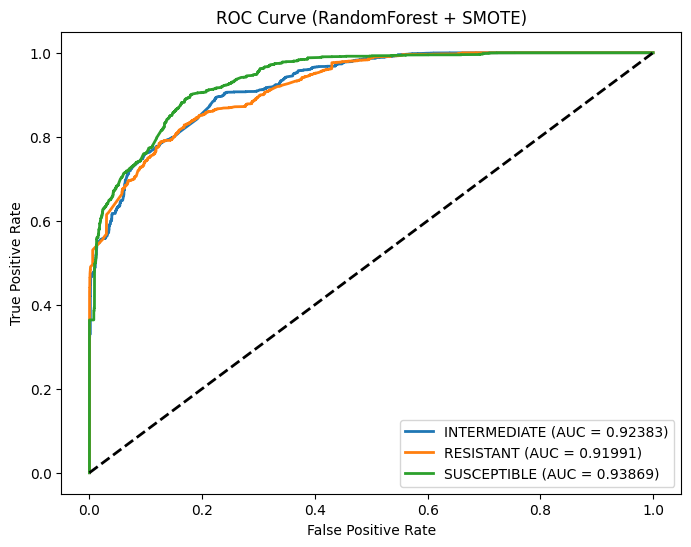

=== AUC Score per Class ===
INTERMEDIATE: 0.9238
RESISTANT: 0.9199
SUSCEPTIBLE: 0.9387


In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# === ROC Curve (Multi-Class) ===

# Pastikan label-nya diurutkan konsisten
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilitas prediksi dari model
y_score = rf_modelSMOTE.predict_proba(X_test)

# Dictionary untuk simpan skor AUC
roc_auc_scores = {}

plt.figure(figsize=(8, 6))

# Loop untuk setiap kelas
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i],
                            y_score[i][:, 1] if isinstance(y_score, list) else y_score[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[class_name] = roc_auc  # simpan nilai AUC

    # Plot ROC
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.5f})")

# Plot diagonal random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForest + SMOTE)")
plt.legend(loc="lower right")
plt.show()

# === Print AUC per kelas ===
print("=== AUC Score per Class ===")
for cls, score in roc_auc_scores.items():
    print(f"{cls}: {score:.4f}")


Validasi

In [11]:
#SMOTE Model

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Load data validasi ===
df_val = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/DataVal.csv")

df_val = df_val.drop(columns=[
    "anon_id", "pat_enc_csn_id_coded", "order_time_jittered_utc",
    "organism", "order_proc_id_coded"
], errors="ignore")


# === 2. Samakan preprocessing target EXACTLY seperti data training ===
df_val["susceptibility"] = df_val["susceptibility"].str.strip().str.upper()

# === 3. Gunakan fitur yang sama seperti saat training ===
categorical_features = ["antibiotic", "medication_category", "medication_name",
                        "prior_organism", "culture_description"]

special_numeric = ["prior_infecting_organism_days_to_culutre",
                   "medication_time_to_culturetime"]

target = "susceptibility"

exclude_cols = [target] + categorical_features
numeric_features = [c for c in df_val.columns if c not in exclude_cols]

X_val = df_val[categorical_features + numeric_features]
y_val = df_val[target]

# === 4. Prediksi menggunakan pipeline model ===
y_pred = rf_modelSMOTE.predict(X_val)

# === 5. Evaluasi ===
print("=== Classification Report (Validation Data) ===")
print(classification_report(y_val, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_val, y_pred))


=== Classification Report (Validation Data) ===
              precision    recall  f1-score   support

INTERMEDIATE       0.84      0.74      0.79      8970
   RESISTANT       0.80      0.81      0.80      9618
 SUSCEPTIBLE       0.57      0.74      0.64      3227

    accuracy                           0.77     21815
   macro avg       0.74      0.76      0.74     21815
weighted avg       0.78      0.77      0.77     21815


=== Confusion Matrix ===
[[6631 1546  793]
 [ 820 7750 1048]
 [ 443  385 2399]]
